#  This is the Entire PipeLine


### Setting Up for the input

In [1]:
import torch
import tiktoken


In [2]:
tokenizer = tiktoken.get_encoding( "gpt2" )
text = ( "Hello World ")
integers = tokenizer.encode( text )
print ( integers )  

[15496, 2159, 220]


In [16]:
GPT_CONFIG_124M = {
    "vocab_size" : 50257,
    "context_length" : 256,
    "emb_dim" : 768,
    "n_heads" : 12,
    "n_layers" : 12,
    "drop_rate" : 0.1,
    "qkv_bias" : False
}

In [3]:
import torch 
import torch.nn as nn


### Layer Normalisation and Feed Forward Neural Network


In [4]:
class LayerNorm( nn.Module ):
    def __init__( self , emb_dim ):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter( torch.ones( emb_dim ))
        self.shift = nn.Parameter( torch.zeros( emb_dim ))


    def forward( self , x ):
        mean = x.mean( dim = -1 , keepdim = True )
        var = x.var( dim = -1 , keepdim = True , unbiased = True )
        norm_x = ( x - mean ) / torch.sqrt( var + self.eps )
        return self.scale * norm_x + self.shift
    

class GELU( nn.Module ):
    def __init__( self  ):
        super().__init__()

    def forward( self , x ):
        return 0.5 * x * ( 1 + torch.tanh( 
            torch.sqrt( torch.tensor( 2.0 / torch.pi )) * 
            ( x + 0.044715 * torch.pow( x , 3 )) 
        ))

class FeedForward( nn.Module ):
    def __init__( self , cfg ):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear( cfg["emb_dim" ] , 4 * cfg["emb_dim" ] ),
            GELU(),
            nn.Linear( 4 * cfg[ "emb_dim"] , cfg[ "emb_dim" ]),

        )

    def forward( self , x ):
        return self.layers( x )

### MutiHead Attention Mech


In [5]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim) 
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2) 
        
        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

### Transformer Class


In [6]:
class TransformerBlock( nn.Module ):
    def __init__( self , cfg ):
        super().__init__()
        self.att = MultiHeadAttention( 
            d_in = cfg[ "emb_dim"],
            d_out = cfg[ "emb_dim"],
            context_length = cfg[ "context_length"],
            num_heads = cfg[ "n_heads"],
            dropout = cfg[ "drop_rate"],
            qkv_bias = cfg[ "qkv_bias"],

        )
        self.ff = FeedForward( cfg )
        self.norm1 = LayerNorm( cfg[ "emb_dim"])
        self.norm2 = LayerNorm( cfg[ "emb_dim"])
        self.drop_shortcut = nn.Dropout( cfg["drop_rate"])

    def forward( self , x ):
        shortcut = x
        x = self.norm1( x )
        x = self.att( x )
        x = self.drop_shortcut( x )
        x = x + shortcut

        shortcut = x
        x = self.norm2( x )
        x = self.ff( x )
        x = self.drop_shortcut( x )
        x = x + shortcut


        return x

### Now to Code the GPT Architecture


In [7]:
class GPTModel( nn.Module ):
    def __init__(self , cfg ):
        super().__init__()
        self.tok_emb = nn.Embedding( cfg["vocab_size"] , cfg["emb_dim"])
        self.pos_emb = nn.Embedding( cfg["context_length" ] , cfg["emb_dim"])
        self.drop_emb = nn.Dropout( cfg["drop_rate"])

        self.trf_blocks = nn.Sequential( 
            *[TransformerBlock( cfg ) for _ in range(cfg[ "n_layers"])])
        
        self.final_norm = LayerNorm( cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"] , cfg[ "vocab_size"], bias=  False
        )

    def forward( self , in_idx ):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb( in_idx )
        pos_embeds = self.pos_emb( torch.arange( seq_len , device = in_idx.device ))
        x = tok_embeds + pos_embeds
        x = self.drop_emb( x )
        x = self.trf_blocks( x )
        x = self.final_norm( x )
        logits = self.out_head( x )
        return logits

In [24]:
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)
torch.manual_seed( 123 )
model = GPTModel( GPT_CONFIG_124M )
out = model( batch )
print( "Input batch : \n" , batch )
print( "Output : \n" , out.shape )
print( out )

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
Input batch : 
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
Output : 
 torch.Size([2, 4, 50257])
tensor([[[-1.7930e-01,  2.8437e-01, -7.6031e-01,  ..., -4.8328e-01,
          -4.2459e-01, -1.7183e-01],
         [-6.2540e-01, -3.7472e-01, -9.6911e-01,  ...,  1.9217e-01,
          -1.3227e+00, -2.7610e-01],
         [ 5.1774e-01,  1.3858e-01,  2.4931e-01,  ...,  3.5055e-01,
          -7.7138e-02, -7.9681e-02],
         [-2.5624e-01, -6.9668e-01, -9.9379e-01,  ..., -4.4323e-02,
           6.1901e-02,  1.3455e-01]],

        [[-2.2345e-01,  1.1610e-01, -9.9719e-01,  ..., -1.5698e-01,
          -4.4743e-01, -2.8685e-02],
         [-8.7201e-01, -3.9409e-01, -1.1089e+00,  ...,  3.3024e-01,
          -9.2300e-02, -9.1573e-05],
         [ 4.5925e-01, -1.4261e-01, -1.2172e-01,  ...,  2.7475e-01,
           5.8875e-02, -9.0158e-02],
         [-6.2152e-01, -4.4847e-01, -4.7587e-01,  ..., -3.6475e-01,
    

### find the total Number of Parameters

In [11]:
total_params = sum( p.numel() for p in model.parameters())
print(f"Total number of Parameters :  { total_params:,}")

Total number of Parameters :  162,419,712


In [12]:
print( "Token Embedding layer shape: " , model.tok_emb.weight.shape )
print( "Output layer shape: " , model.out_head.weight.shape )

Token Embedding layer shape:  torch.Size([50257, 768])
Output layer shape:  torch.Size([50257, 768])


In [13]:
total_params_gpt2 = total_params - sum( p.numel() for p in model.out_head.parameters())
print( f"Number of Tainable parameters are :{total_params_gpt2 :,}")

Number of Tainable parameters are :123,822,336


In [8]:
def generate_text_sample( model , idx , max_new_tokens , context_size ):
    # idx is the ( batch , n_tokens ) array of the indices in the current context
    for _ in range( max_new_tokens ):
        idx_cond = idx[:, -context_size: ]
        with torch.no_grad():
            logits = model( idx_cond )

        logits = logits[ :, -1, :]

        probas = torch.softmax( logits , dim = -1 )
    
        idx_next = torch.argmax( probas , dim = -1 , keepdim = True )

        idx = torch.cat((idx , idx_next ), dim = 1 )

    return idx


In [15]:
start_content = "Hello, I am"
encoded = tokenizer.encode( start_content )
print( "encoded : " , encoded )
encoded_tensor = torch.tensor( encoded ).unsqueeze( 0 )
print( "Encoded_tensor.shape : ", encoded_tensor.shape )

encoded :  [15496, 11, 314, 716]
Encoded_tensor.shape :  torch.Size([1, 4])


In [16]:
model.eval()
out = generate_text_sample( 
    model= model,
    idx = encoded_tensor,
    max_new_tokens= 6,
    context_size= GPT_CONFIG_124M["context_length"]
)
print("Output : ", out )
print("Output Length : ", len(out[ 0 ]))

Output :  tensor([[15496,    11,   314,   716, 13240, 11381,  4307,  7640, 16620, 34991]])
Output Length :  10


In [17]:
decoded_text = tokenizer.decode( out.squeeze(0).tolist())
print( decoded_text )
print( "These are random text , the Parameter of the GPT is now set to be learn during the training")

Hello, I am Laur inhab DistrinetalkQueue
These are random text , the Parameter of the GPT is now set to be learn during the training


### Encoder and Decoder

In [65]:
import tiktoken

def text_to_token_ids( text , tokenizer ):
    encoded = tokenizer.encode( text , allowed_special = {'<|endoftext|>'})
    encoded_tensor = torch.tensor( encoded ).unsqueeze( 0 )
    return encoded_tensor

def token_ids_to_text( token_ids , tokenizer ):
    flat = token_ids.squeeze( 0 )
    return tokenizer.decode( flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_sample(
    model = model,
    idx = text_to_token_ids( start_context , tokenizer ),
    max_new_tokens= 10,
    context_size= GPT_CONFIG_124M["context_length"] 
)

print( "output text :\n " , token_ids_to_text( token_ids , tokenizer ))

output text :
  Every effort moves you,,,,,,,,,,


### Defining Loss Function


In [19]:
inputs = torch.tensor([[ 16833 , 3626 , 6100 ],
                       [ 40 , 1107 , 588 ]])

targets = torch.tensor([[ 3626, 6100, 345 ],
                        [ 1107, 588,  11311 ]])

In [20]:
with torch.no_grad():
    logits = model( inputs )

probas = torch.softmax( logits, dim = -1 )
print( probas.shape )

torch.Size([2, 3, 50257])


In [21]:
token_ids = torch.argmax( probas , dim = -1 , keepdim = True )
print("token ids : \n" , token_ids )

token ids : 
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [22]:
# Lets decode it
print( f"Target batch 1: { token_ids_to_text( targets[ 0 ] , tokenizer )}")
print( f"output batch 1: { token_ids_to_text( token_ids[ 0 ].flatten() , tokenizer )}")

Target batch 1:  effort moves you
output batch 1:  Armed heNetflix


### Corss Entropy Loss

In [23]:
text_idx = 0 
target_probas_1 = probas[ text_idx , [ 0 , 1 , 2 ] , targets[ text_idx ]]
print( "Text 1 : ", target_probas_1 )

text_idx = 1
target_probas_2 = probas[ text_idx , [ 0 , 1 , 2 ] , targets[ text_idx ]]
print( "Text 2 : " , target_probas_2)

Text 1 :  tensor([7.4514e-05, 3.1054e-05, 1.1567e-05])
Text 2 :  tensor([1.0343e-05, 5.6737e-05, 4.7620e-06])


In [24]:
# Taking the Log
log_probas = torch.log( torch.cat(( target_probas_1 , target_probas_2)))
print( log_probas )

tensor([ -9.5045, -10.3798, -11.3674, -11.4792,  -9.7771, -12.2549])


In [25]:
# Takin  the mean
avg_log_probas = torch.mean( log_probas )
print( avg_log_probas )

tensor(-10.7938)


In [26]:
# (-)ve of the log likelihood
neg_avg_log_probas = -1 * avg_log_probas
print(neg_avg_log_probas)

tensor(10.7938)


In [27]:
# Alternate  way of doing it 
print( "Logits Shape : " , logits.shape )
print( "Target Shape : ", targets.shape )

Logits Shape :  torch.Size([2, 3, 50257])
Target Shape :  torch.Size([2, 3])


In [28]:
# Can be done in few line of codes
logits_flat = logits.flatten( 0 , 1 )
targets_flat = targets.flatten()

print( "Flattened Logits : " , logits_flat.shape )
print( "Flattened Target : ", targets_flat.shape )

Flattened Logits :  torch.Size([6, 50257])
Flattened Target :  torch.Size([6])


In [29]:
# Loss calculation through one line of code
loss = torch.nn.functional.cross_entropy( logits_flat , targets_flat )
print( loss )

tensor(10.7938)


In [30]:
perplexcity = torch.exp( loss )
print( perplexcity )

tensor(48717.6875)


# Running on Toy Data Set - The Verdict

In [31]:
import os
import urllib.request

# file_path = "the-verdict.txt"
# url = "https://github.com/rasbt/LLMs-from-scratch/blob/main/ch02/01_main-chapter-code/the-verdict.txt"

# if not os.path.exists( file_path ):
#     with urllib.request.urlopen( url ) as response :
#         text_data = response.read().decode('utf-8')

#     with open( file_path , "w" , encoding='utf-8' ) as file:
#         file.write( text)
with open("/Users/adityaastronomy/Downloads/the_Verdict.txt", "r", encoding="utf-8") as file :
    text_data = file.read()


In [32]:
# print firts 100 words
print( text_data[:99])

The Verdict
Edith Wharton

1908

Exported from Wikisource on May 20, 2024

1

I HAD always thought


In [33]:
# Print the last 1000 characters
print( text_data[-99 :])

o
Blurpeace
Dschwen
Boris23
KABALINI
Bromskloss
Tene~commonswiki
AzaToth
Bender235
PatríciaR

22




In [34]:
total_characters = len( text_data )
total_token = len( tokenizer.encode( text_data ))
print( "Characters : ", total_characters )
print( "Tokens : ", total_token )

Characters :  21871
Tokens :  5898


### Spilting the DataSet

In [35]:
from torch.utils.data import Dataset, DataLoader

class GPTDatasetV1( Dataset ):
    def __init__( self , txt, tokenizer , max_length , stride ):
        self.input_ids = []
        self.target_ids = []
        # Tokenise the entire text 
        token_ids = tokenizer.encode( txt , allowed_special= {"<|endoftext|>"})
        # use of sliding window to chunk the book into overlapping sequene of max_length 

        for i in range( 0 , len( token_ids ) - max_length , stride ):
            input_chunk = token_ids[ i:i + max_length ]
            target_chunk = token_ids[ i + 1:i + max_length + 1 ]
            self.input_ids.append( torch.tensor( input_chunk ))
            self.target_ids.append( torch.tensor( target_chunk ))
    
    def __len__( self ):
        return len( self.input_ids )
    
    def __getitem__(self, index):
        return self.input_ids[ index ], self.target_ids[ index ]
    

def create_dataloader_v1( txt , batch_size = 4 , max_length = 256 , stride = 126 , shuffle = True , drop_last = True , num_workers = 0 ):
    # Initialise the tokenizer
    tokenizer = tiktoken.get_encoding( "gpt2")
    # create dataset 
    dataset = GPTDatasetV1( txt , tokenizer , max_length , stride )

    # create dataloader
    dataloader = DataLoader(
        dataset , 
        batch_size= batch_size ,
        shuffle= shuffle,
        drop_last= drop_last,
        num_workers= num_workers
    )
    return dataloader

In [36]:
# Train Validation Ratio
train_ratio = 0.90
split_idx = int( train_ratio * len( text_data ))
train_data = text_data[ : split_idx ]
val_data = text_data[ split_idx : ]

torch.manual_seed( 123 )

train_loader = create_dataloader_v1(
    train_data,
    batch_size= 2,
    max_length= GPT_CONFIG_124M["context_length"],
    stride= GPT_CONFIG_124M["context_length"],
    drop_last= True,
    shuffle = True,
    num_workers= 0 # this is used for the parallel processing
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size= 2,
    max_length= GPT_CONFIG_124M["context_length"],
    stride= GPT_CONFIG_124M["context_length"],
    drop_last= False,
    shuffle = False,
    num_workers= 0 # this is used for the parallel processing
)

In [37]:
# Sanity Check
if total_token * ( train_ratio ) < GPT_CONFIG_124M["context_length"]:
    print( "Not Enough token for the training loader ")

if( total_token * ( 1 - train_ratio ) < GPT_CONFIG_124M["context_length"]):
    print( "Not Enough token for the Validation Loader ")

print( total_token * ( train_ratio ))
print( total_token * ( 1 - train_ratio ))

5308.2
589.7999999999998


In [38]:
print( "Train Loader: ")
for x, y in train_loader:
    print( x.shape , y.shape )


print( "validation Loader: ")
for x, y in val_loader:
    print( x.shape , y.shape )

print( len( train_loader ))
print( len( val_loader ))

Train Loader: 
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
validation Loader: 
torch.Size([2, 256]) torch.Size([2, 256])
10
1


In [39]:
torch.manual_seed( 123 )
model = GPTModel( GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [40]:
# calculate the loss of the output with the targets 

def calc_loss_batch( input_batch , target_batch , model , device ):
    input_batch , target_batch = input_batch.to( device ), target_batch.to( device )
    logits = model( input_batch )
    loss = torch.nn.functional.cross_entropy( logits.flatten( 0 , 1 ) , target_batch.flatten())
    return loss
 
def cal_losss_loader( data_loader, model, device, num_batches = None ):
    total_loss = 0.
    if( len(data_loader)) == 0 :
        return float("nan")
    elif num_batches is None:
        num_batches = len( data_loader )

    else :
        num_batches = min( num_batches , len( data_loader ))
    
    for i, ( input_batch , target_batch ) in enumerate( data_loader ):
        if i < num_batches :
            loss = calc_loss_batch( input_batch , target_batch , model , device )
            total_loss += loss.item()

        else: 
            break

    return total_loss/ num_batches


In [41]:
device = torch.device(  "cpu")
model.to( device )

torch.manual_seed( 123 )
with torch.no_grad():
    train_loss = cal_losss_loader( train_loader , model , device )
    val_loss = cal_losss_loader( val_loader , model , device )

print("Training Loss : " , train_loss )
print("Validation Loss : " , val_loss )

Training Loss :  10.978403282165527
Validation Loss :  11.004152297973633


## Training Loop for the LLM

In [59]:
def train_model_sample( model , train_loader , val_loader , optimizer, device , num_epochs, eval_freq , eval_iter, start_context, tokenizer ):
    # Initialise the list to track losses and token seen
    train_losses , val_losses , track_token_seen = [] , [] , []
    token_seen , global_step = 0, -1

    # Main triaining loop
    
    for epoch in range( num_epochs ):
        model.train()  # Set model to training mode

        for input_batch , traget_batch in train_loader : 
            optimizer.zero_grad() # Reset the Loss Gradient from the previous batch
            loss = calc_loss_batch( input_batch , traget_batch , model , device )
            loss.backward()     # Calculate the loss gradient 
            optimizer.step()    #update the model weights 
            token_seen += input_batch.numel()
            global_step += 1

            #Optinal Evalution Step
            if global_step % eval_freq == 0 :
                train_loss , val_loss = evaluated_model(
                    model, train_loader, val_loader, device , eval_iter 
                )
                train_losses.append( train_loss )
                val_losses.append( val_loss )
                track_token_seen.append( token_seen )
                print( f"Ep {epoch + 1 } ( Step { global_step :06d}) :  "
                        f" Train Loss { train_loss:.3f}, Val Loss { val_loss :.3f}" )
        # Print the sample text after each epoch 

        generate_and_print_sample( 
            model , tokenizer , device , start_context 
        )    

    return train_losses , val_losses , track_token_seen 




In [60]:
def evaluated_model( model , train_loader , val_loader , device , eval_iter ):
    model.eval()
    with torch.no_grad():
        train_loss = cal_losss_loader( train_loader , model ,device , num_batches = eval_iter )
        val_loss = cal_losss_loader( val_loader , model , device , num_batches = eval_iter )
    model.train()
    return train_loss , val_loss 


In [44]:
def generate_and_print_sample( model , tokenizer , device , start_context ):
    model.eval()
    context_size = model.pos_emb.weight.shape[ 0 ]
    encoded = text_to_token_ids( start_context , tokenizer ).to( device )
    with torch.no_grad():
        token_ids = generate_text_sample(
            model = model ,
            idx = encoded ,
            max_new_tokens= 50 ,
            context_size= context_size
        )
    decoded_text = token_ids_to_text( token_ids , tokenizer )
    print( decoded_text.replace("\n" , " ")) #compact print format 
    model.train()

In [61]:
import time 
start_time = time.time()

torch.manual_seed( 123 )
model = GPTModel( GPT_CONFIG_124M )
model.to( device )
optimizer = torch.optim.AdamW( model.parameters() , lr = 0.0004 , weight_decay = 0.1 )  # we are using AdamW optimizer 

num_epoches = 10
train_losses , val_losses , token_seen = train_model_sample(
    model , train_loader , val_loader , optimizer , device , num_epochs = num_epoches , eval_freq = 5 , eval_iter = 5 , 
    start_context= "Every effort moves you" , tokenizer= tokenizer 
)

end_time = time.time()
execution_time_minutes = ( end_time - start_time ) / 60 
print( f"Training Completed in { execution_time_minutes:.2f} minutes ")


Ep 1 ( Step 000000) :   Train Loss 9.859, Val Loss 9.933
Ep 1 ( Step 000005) :   Train Loss 8.173, Val Loss 8.615
Every effort moves you, ,,, ,,,,,, ,,,, ,,, ,,, ,,, ,, ,,,, ,,, the ,,,,,,,
Ep 2 ( Step 000010) :   Train Loss 6.855, Val Loss 7.860
Ep 2 ( Step 000015) :   Train Loss 6.205, Val Loss 7.748
Every effort moves you, , , , , ,,  , ,  ,  , , , , , , , , , , , , , , 
Ep 3 ( Step 000020) :   Train Loss 6.140, Val Loss 7.885
Ep 3 ( Step 000025) :   Train Loss 5.808, Val Loss 7.908
Every effort moves you " ", " " ", and " " " " " " ", the " " " " " " " " " ",
Ep 4 ( Step 000030) :   Train Loss 5.683, Val Loss 7.975
Ep 4 ( Step 000035) :   Train Loss 5.492, Val Loss 7.925
Every effort moves you, and "I "I "II had "I, and "I "I "II the "I "I had the "I "I "II "I
Ep 5 ( Step 000040) :   Train Loss 4.850, Val Loss 7.887
Ep 5 ( Step 000045) :   Train Loss 4.466, Val Loss 7.830
Every effort moves you " "I to my way to "I could it. "I "I " to have was not that, and it, and "I had to have 

### The Training Loss Become small but the Validation Loss become stagnent after sometime 

Note: you may need to restart the kernel to use updated packages.


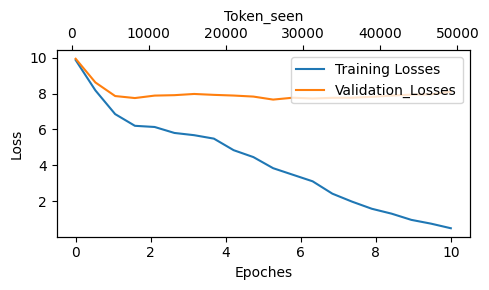

In [62]:
%pip install matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses( epoches_seen , token_seen , train_losses , val_losses ):
    fig , ax1 = plt.subplots( figsize= ( 5 , 3 ))

    # Plot the training and validation losses against the epoches 
    ax1.plot( epoches_seen , train_losses , label = "Training Losses" )
    ax1.plot( epoches_seen , val_losses , label = "Validation_Losses")
    ax1.set_xlabel( "Epoches")
    ax1.set_ylabel( "Loss" )
    ax1.legend( loc = "upper right")
    ax1.xaxis.set_major_locator( MaxNLocator( integer = True ))

    ax2 = ax1.twiny()
    ax2.plot( token_seen , train_losses , alpha = 0 )
    ax2.set_xlabel( "Token_seen")

    fig.tight_layout()
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace( 0 , num_epoches , len( train_losses ))
plot_losses( epochs_tensor , token_seen , train_losses , val_losses )

## Decoding Strategies to Control the Randomness

In [63]:
model.to("cpu")
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [64]:
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_sample(
    model = model,
    idx = text_to_token_ids( "Every effort moves you" , tokenizer ),
    max_new_tokens = 25,
    context_size = GPT_CONFIG_124M[ "context_length" ]
    )

print( "Output test: \n" , token_ids_to_text( token_ids , tokenizer ))

Output test: 
 Every effort moves you know; and having, on my way to Monte
3

Carlo, caught a glimpse of Jack's balust


## Decoding Strategy 1: Temperature Scaling 

In [65]:
# Replace the argmax with the probability distribution

vocab = {
    "closer" : 0,
    "every" : 1,
    "effort" : 2,
    "forward" : 3,
    "inches" : 4,
    "moves" : 5,
    "pizza" : 6,
    "towards" : 7,
    "you" : 8,
}

reverse_vocab = { v : k for k , v in vocab.items() } 

In [66]:
# Suppose the start context is "Enery effort moves you" therefore the output, logits tensor is
next_token_logits = torch.tensor(
    [ 4.51 , 0.89 , -1.90, 6.75 , 1.63 , -1.62, -1.89 , 6.28 ,1.79 ]
)


In [67]:
probas = torch.softmax( next_token_logits , dim = 0 )

print( probas )
next_token_id = torch.argmax( probas ).item()
print( next_token_id )
print( reverse_vocab[ next_token_id ])

tensor([6.0907e-02, 1.6313e-03, 1.0019e-04, 5.7212e-01, 3.4190e-03, 1.3257e-04,
        1.0120e-04, 3.5758e-01, 4.0122e-03])
3
forward


In [68]:
# Now replacing the argmax with multinomial function 
torch.manual_seed( 123 )
next_token_id = torch.multinomial( probas , num_samples= 1 ).item()
print( reverse_vocab[ next_token_id ])

forward


In [69]:
# Running the funtions 1000 times to see the variance in the answer but most of the time it will be the "forward"
def print_sample_tokens( probas ):
    torch.manual_seed( 123 )
    sample = [torch.multinomial( probas , num_samples = 1).item() for i in range( 1000 )]
    sampled_ids = torch.bincount( torch.tensor( sample ))
    for i , freq in enumerate( sampled_ids ):
        print( f"{freq} x {reverse_vocab[ i ]}")

print_sample_tokens( probas )

73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x towards


In [70]:
# Applying the fancy concept of the Temperature
def softmax_with_temperature( logits , temperature ):
    scaled_logits = logits / temperature
    return torch.softmax( scaled_logits , dim = 0 )

# Temperature Values 
temperatures = [ 1 , 0.1 , 5 ]

# calculate scaled probabilities 
scaled_probas = [ softmax_with_temperature( next_token_logits , T ) for T in temperatures]

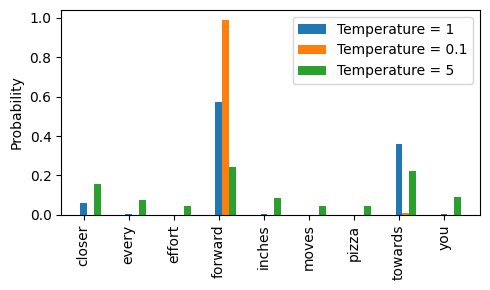

In [71]:
# plotting
x = torch.arange( len( vocab ))
bar_width = 0.15 

fig, ax = plt.subplots( figsize = ( 5 , 3 ))
for i , T in enumerate( temperatures ):
    rects = ax.bar( x + i * bar_width , scaled_probas[ i ] , bar_width , label = f'Temperature = {T}')

ax.set_ylabel( 'Probability')
ax.set_xticks( x )
ax.set_xticklabels( vocab.keys() , rotation = 90 )
ax.legend()

plt.tight_layout()
plt.savefig("temperature-plot.pdf")
plt.show()

In [72]:
next_token_logits2 = next_token_logits / 0.1 
probas2 = torch.softmax( next_token_logits2 , dim = 0 )

print( probas2 )

tensor([1.8530e-10, 3.5189e-26, 2.6890e-38, 9.9099e-01, 5.7569e-23, 4.4220e-37,
        2.9718e-38, 9.0133e-03, 2.8514e-22])


## Decoding Strategy 2: Top - K Sampling

In [73]:
top_k = 3
top_logits , top_pos = torch.topk( next_token_logits , top_k )
print("Top Logits : ", top_logits )
print("Top Positions : ", top_pos )

Top Logits :  tensor([6.7500, 6.2800, 4.5100])
Top Positions :  tensor([3, 7, 0])


In [74]:
new_logits = torch.where( 
    condition= next_token_logits < top_logits[ -1 ],
    input = torch.tensor( float("-inf")),
    other = next_token_logits
)
print( new_logits )

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [75]:
topk_probas = torch.softmax( new_logits , dim = 0 )
print( topk_probas )

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


## Top k + Temperature Sampling

In [28]:
def generate( model , idx , max_new_tokens , context_size , temperarture = 0.0 , top_k = None , eos_id = None ):

    for _ in range( max_new_tokens ):
        idx_cond = idx[ :, -context_size:]
        with torch.no_grad():
            logits = model( idx_cond )
        logits = logits[ :, -1, : ]

        if top_k is not None :
            # Keep only top k values 
            top_logits, _ = torch.topk( logits , top_k )
            min_val = top_logits[ : ,-1 ]
            logits = torch.where( logits < min_val , torch.tensor( float("-inf")).to(logits.device ) , logits )
            
        if temperarture > 0.0 :
            logits = logits / temperarture 

            # Apply softmax to get the probability 
            probas = torch.softmax( logits , dim = -1 )

            idx_next = torch.multinomial( probas , num_samples = 1 )

        else:
            idx_next = torch.argmax( logits , dim = -1 , keepdim = True )

        if idx_next == eos_id :
            break

        idx = torch.cat(( idx , idx_next ) , dim = 1 )

    return idx 

In [77]:
torch.manual_seed( 123 )

token_ids = generate(
    model = model,
    idx = text_to_token_ids( "Every effort moves you" , tokenizer ),
    max_new_tokens = 15 ,
    context_size= GPT_CONFIG_124M["context_length"],
    top_k= 25 , 
    temperarture= 2
)

print("Output text \n" , token_ids )
print( token_ids_to_text( token_ids, tokenizer ))

Output text 
 tensor([[ 6109,  3626,  6100,   345,   821,   553,   673,  3114,   340,   284,
           502,   783,   339,  8288,  4964,   502,   466, 22486,    11]])
Every effort moves you're," she looked it to me now he liked watching me do balancing,


## Loading and saving the model weight in Pytorch 

In [78]:
model = GPTModel(GPT_CONFIG_124M)
torch.save( model.state_dict() , "model.pth")

In [79]:
# Lets now check by loading and seeing its parameter
model = GPTModel( GPT_CONFIG_124M )
model.load_state_dict( torch.load( "model.pth"))
model.eval()

/var/folders/n9/j8l4b0cj5zqdl0273gsv8jgh0000gn/T/ipykernel_41380/3255646474.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict( torch.load( "model.pth

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [80]:
optimizer = torch.optim.AdamW( model.parameters() , lr = 0.0004 , weight_decay= 0.1 )

torch.save(
    {
    "model_state_dict" : model.state_dict(),
    "optimizer_state_dict" : optimizer.state_dict(),
    },
    "model_and_optimizer.pth"

)


In [81]:
checkpoints = torch.load( "model_and_optimizer.pth")
model = GPTModel( GPT_CONFIG_124M )
model.load_state_dict( checkpoints["model_state_dict"])
optimizer = torch.optim.AdamW( model.parameters() , lr = 5e-4 , weight_decay= 0.1)
optimizer.load_state_dict( checkpoints["optimizer_state_dict"])
model.train()

/var/folders/n9/j8l4b0cj5zqdl0273gsv8jgh0000gn/T/ipykernel_41380/3312451483.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoints = torch.load( "model_and_optimize

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

## Loading Pretrained weights from Open AI

In [9]:
%pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [10]:
%pip install tensorflow
%pip install tqdm
%pip install tensorflow>=2.15.0 tqdm>=4.66

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
zsh:1: 2.15.0 not found
Note: you may need to restart the kernel to use updated packages.


In [12]:
import tensorflow as tf
import tqdm

print( "Tensorflow version ", tf.__version__ )
print( "tqdm Version ", tqdm.__version__ )


Tensorflow version  2.18.0
tqdm Version  4.67.1


In [5]:
from gpt_download3 import download_and_load_gpt2

In [6]:
settings, param =  download_and_load_gpt2( model_size= "124M" , models_dir= "/Users/adityaastronomy/Desktop/LLM/")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: /Users/adityaastronomy/Desktop/LLM/124M/checkpoint


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: /Users/adityaastronomy/Desktop/LLM/124M/encoder.json


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: /Users/adityaastronomy/Desktop/LLM/124M/hparams.json


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: /Users/adityaastronomy/Desktop/LLM/124M/model.ckpt.data-00000-of-00001


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: /Users/adityaastronomy/Desktop/LLM/124M/model.ckpt.index


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: /Users/adityaastronomy/Desktop/LLM/124M/model.ckpt.meta


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: /Users/adityaastronomy/Desktop/LLM/124M/vocab.bpe


In [7]:
print( "Setting : ", settings)
print( 'Parameter dictionary keys : ' , param.keys())

Setting :  {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys :  dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [8]:
# Lets just check the value of the param[ wte ]
print(param['wte'])
print("Token Embeddings weight tensor dimensions : " , param[ "wte" ].shape )

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token Embeddings weight tensor dimensions :  (50257, 768)


In [14]:
model_configs = {
    "gpt2-small (124M)" : { "emb_dim" : 768 , "n_layers" : 12 , "n_heads" : 12 },
    "gpt2-medium (355M)" : { "emb_dim" : 1024 , "n_layers" : 24 , "n_heads" : 16 }, 
    "gpt2-large (774M)" : { "emb_dim" : 1280 , "n_layers" : 36 , "n_heads" : 20 }, 
    "gpt2-xl (1558M)" : { "emb_dim" : 1600 , "n_layers" : 48 , "n_heads" : 25 }, 
}

model_name = "gpt2-small (124M)"
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update( model_configs[ model_name])

In [20]:
NEW_CONFIG.update( {"context_length" : 1024 , "qkv_bias" : True })
gpt = GPTModel( NEW_CONFIG )
gpt.eval()
print( NEW_CONFIG)
print( GPT_CONFIG_124M )

{'vocab_size': 50257, 'context_length': 1024, 'emb_dim': 768, 'n_heads': 12, 'n_layers': 12, 'drop_rate': 0.1, 'qkv_bias': True}
{'vocab_size': 50257, 'context_length': 256, 'emb_dim': 768, 'n_heads': 12, 'n_layers': 12, 'drop_rate': 0.1, 'qkv_bias': False}


In [13]:
def assign( left , right ):
    if left.shape != right.shape:
        raise ValueError( f"Shape mismatched. Left: { left.shape } , Right : { right.shape }")
    
    return torch.nn.Parameter( torch.tensor( right ))

In [14]:
# Now link the GPT Model class with the downloaded weights
import numpy as np

def load_weight_into_gpt( gpt , params ):
    gpt.pos_emb.weight = assign( gpt.pos_emb.weight , params[ 'wpe'])
    gpt.tok_emb.weight = assign( gpt.tok_emb.weight , params[ 'wte'])

    for b in range( len( params[ 'blocks'])):
        # weight part 
        q_w, k_w , v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"] , 3 , axis = -1
        )
        gpt.trf_blocks[b].att.W_query.weight = assign( gpt.trf_blocks[b].att.W_query.weight , q_w.T )
        gpt.trf_blocks[b].att.W_key.weight = assign(  gpt.trf_blocks[b].att.W_key.weight , k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign( gpt.trf_blocks[b].att.W_value.weight , v_w.T )

        # bias part 
        q_b , k_b , v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"] , 3 , axis = -1
        )
        gpt.trf_blocks[b].att.W_query.bias = assign( gpt.trf_blocks[b].att.W_query.bias , q_b )
        gpt.trf_blocks[b].att.W_key.bias = assign(  gpt.trf_blocks[b].att.W_key.bias , k_b )
        gpt.trf_blocks[b].att.W_value.bias = assign( gpt.trf_blocks[b].att.W_value.bias , v_b )

        # output project weight 
        gpt.trf_blocks[b].att.out_proj.weight = assign( gpt.trf_blocks[b].att.out_proj.weight , params["blocks"][b]["attn"]["c_proj"]["w"].T )
        gpt.trf_blocks[b].att.out_proj.bias = assign( gpt.trf_blocks[b].att.out_proj.bias , params["blocks"][b]["attn"]["c_proj"]["b"] )

        # Feed Forward NN -> Fully connected layer
        gpt.trf_blocks[b].ff.layers[0].weight = assign( gpt.trf_blocks[b].ff.layers[0].weight , params["blocks"][b]["mlp"]["c_fc"]["w"].T )
        gpt.trf_blocks[b].ff.layers[0].bias = assign( gpt.trf_blocks[b].ff.layers[0].bias , params["blocks"][b]["mlp"]["c_fc"]["b"] )
        # Projection layer 
        gpt.trf_blocks[b].ff.layers[2].weight = assign( gpt.trf_blocks[b].ff.layers[2].weight , params["blocks"][b]["mlp"]["c_proj"]["w"].T )
        gpt.trf_blocks[b].ff.layers[2].bias = assign( gpt.trf_blocks[b].ff.layers[2].bias , params["blocks"][b]["mlp"]["c_proj"]["b"] )

        # layer normalisation 1 and 2
        gpt.trf_blocks[b].norm1.scale = assign( gpt.trf_blocks[b].norm1.scale , params["blocks"][b]["ln_1"]["g"] )
        gpt.trf_blocks[b].norm1.shift = assign( gpt.trf_blocks[b].norm1.shift , params["blocks"][b]["ln_1"]["b"] )

        gpt.trf_blocks[b].norm2.scale = assign( gpt.trf_blocks[b].norm2.scale , params["blocks"][b]["ln_1"]["g"] )
        gpt.trf_blocks[b].norm2.shift = assign( gpt.trf_blocks[b].norm2.shift , params["blocks"][b]["ln_1"]["b"] )

    # Final parameters left affter transformer block
    gpt.final_norm.scale = assign( gpt.final_norm.scale , params["g"] )
    gpt.final_norm.shift = assign( gpt.final_norm.shift , params["b"] )
    gpt.out_head.weight = assign( gpt.out_head.weight , params["wte"])
    

In [15]:
device = torch.device(  "cpu")
model.to( device )

NameError: name 'model' is not defined

In [26]:
load_weight_into_gpt( gpt , param )
gpt.to( device )

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [37]:
torch.manual_seed( 123 )
token_ids = generate(
    model = model , 
    idx = text_to_token_ids("Every effort moves you" , tokenizer ).to( device ),
    max_new_tokens= 25 ,
    context_size= NEW_CONFIG["context_length"],
    top_k= 50 ,
    temperarture= 1.5

)

print( "Output text: \n" , token_ids_to_text( token_ids, tokenizer )) 

Output text: 
 Every effort moves you correspondence Hawkinsohanorryahn mustardsupport PhDkl missionary Ivory Diaotype tweakingryptionOVA assists 281 contradictionzyk SchumerEdgeitéEMS �


## Fine Tuning for Classification - Classification

In [16]:
import urllib.request
import ssl
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/dataset/228/sms+spam+collection.zip"
zip_path = "/Users/adityaastronomy/Desktop/LLM/sms_spam_collection.zip"
extracted_path = "/Users/adityaastronomy/Desktop/LLM/sms_spam_collection"
data_file_path = Path( extracted_path ) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data( url , zip_path , extracted_path , data_file_path ):
    if data_file_path.exists():
        print( f"{ data_file_path } already exist, skipping the Download Part ")
        return 
    
    # create an unverifed SSL Content
    ssl_context = ssl._create_unverified_context()

    # Download the file 
    with urllib.request.urlopen( url , context = ssl_context ) as response :
        with open( zip_path , "wb" ) as out_file : 
            out_file.write( response.read())

    #unzipping the file
    with zipfile.ZipFile( zip_path , "r" ) as zip_ref:
        zip_ref.extractall( extracted_path )

    #Add .tsv file extension 
    original_file_path = Path( extracted_path ) / "SMSSpamCollection"
    os.rename( original_file_path , data_file_path )
    print( f"file downloaded and saved as { data_file_path }")


download_and_unzip_spam_data( url , zip_path , extracted_path , data_file_path )

## Download this Mannually from the site 


/Users/adityaastronomy/Desktop/LLM/sms_spam_collection/SMSSpamCollection.tsv already exist, skipping the Download Part 


In [17]:
# %pip install pandas
import pandas as pd
df = pd.read_csv( data_file_path , sep = "\t" , header = None , names = ["Labels" , "Text"])
df

,Labels,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [18]:
print( df["Labels"].value_counts())

Labels
ham     4825
spam     747
Name: count, dtype: int64


In [19]:
# This is imbalance data set , now lets make it a balanced data set 
# so we randomly take 747 data ebtries from spam and no spam part 

def create_balanced_dataset( df ):

    num_spam = df[df["Labels"] == "spam"].shape[0]

    # Randomly select 
    ham_subset = df[ df["Labels"] == "ham"].sample( num_spam , random_state = 123 )

    balanced_df = pd.concat( [ ham_subset , df[df["Labels"] == "spam"]])

    return balanced_df 

balanced_df = create_balanced_dataset( df )
print( balanced_df["Labels"].value_counts())
print( balanced_df )

Labels
ham     747
spam    747
Name: count, dtype: int64
     Labels                                               Text
4307    ham  Awww dat is sweet! We can think of something t...
4138    ham                             Just got to  &lt;#&gt;
4831    ham  The word "Checkmate" in chess comes from the P...
4461    ham  This is wishing you a great day. Moji told me ...
5440    ham      Thank you. do you generally date the brothas?
...     ...                                                ...
5537   spam  Want explicit SEX in 30 secs? Ring 02073162414...
5540   spam  ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547   spam  Had your contract mobile 11 Mnths? Latest Moto...
5566   spam  REMINDER FROM O2: To get 2.50 pounds free call...
5567   spam  This is the 2nd time we have tried 2 contact u...

[1494 rows x 2 columns]


In [20]:
balanced_df["Labels"] = balanced_df["Labels"].map( { "ham" : 0 , "spam" : 1 })

In [21]:
print( balanced_df )

      Labels                                               Text
4307       0  Awww dat is sweet! We can think of something t...
4138       0                             Just got to  &lt;#&gt;
4831       0  The word "Checkmate" in chess comes from the P...
4461       0  This is wishing you a great day. Moji told me ...
5440       0      Thank you. do you generally date the brothas?
...      ...                                                ...
5537       1  Want explicit SEX in 30 secs? Ring 02073162414...
5540       1  ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547       1  Had your contract mobile 11 Mnths? Latest Moto...
5566       1  REMINDER FROM O2: To get 2.50 pounds free call...
5567       1  This is the 2nd time we have tried 2 contact u...

[1494 rows x 2 columns]


In [22]:
#Splitin the data set as 70 % - training , 10 % - validation and 20 % -test 
def random_split( df , train_frac , validation_frac ):

    df = df.sample( frac= 1 , random_state= 123 ).reset_index( drop = True )

    train_end = int( len(df) * train_frac )
    validation_end = train_end + int( len( df ) * validation_frac )

    # Diving the df
    train_df = df[ : train_end ]
    validation_df = df[ train_end : validation_end ]
    test_df = df[ validation_end : ]

    return train_df , validation_df , test_df

train_df , validation_df , test_df = random_split( balanced_df , 0.7 , 0.1 )


In [23]:
print( len( train_df ))
print( len( validation_df ))
print( len( test_df ))

1045
149
300


In [24]:
# Now save the dataset 
train_df.to_csv( "train.csv" , index = None )
validation_df.to_csv( "validation.csv" , index = None )
test_df.to_csv( "test.csv" , index = None )

In [25]:
# Creating Data Loaders
import torch 
from torch.utils.data import Dataset

class SpamDataset( Dataset ):
    def __init__( self , csv_file , tokenizer , max_length = None , pad_token_id = 50256 ):
        self.data = pd.read_csv( csv_file )

        # Pre tokenize text 
        self.encoded_texts = [
            tokenizer.encode( text ) for text in self.data["Text"]
        ]

        if max_length is None:
            self.max_length = self._longest_encoded_length()

        else:
            self.max_length = max_length

            # Truncate the seq 
            self.encoded_texts = [
                encoded_text[ : self.max_length ]
                for encoded_text in self.encoded_texts 
            ]

        # Padding
        self.encoded_texts = [ encoded_text + [ pad_token_id ] * ( self.max_length - len( encoded_text ))
                              for encoded_text in self.encoded_texts 
                              ]
        
    def __getitem__( self , index ):
        encoded = self.encoded_texts[ index ]
        label = self.data.iloc[ index ][ 'Labels']
        return (
            torch.tensor( encoded , dtype = torch.long ),
            torch.tensor( label , dtype = torch.long )
        )
    
    def __len__( self ):
        return len( self.data )
    
    def _longest_encoded_length( self ):
        max_length = 0
        for encoded_text in self.encoded_texts : 
            encoded_length = len( encoded_text )
            if( encoded_length > max_length ):
                max_length = encoded_length
        return max_length



In [26]:
train_dataset = SpamDataset(
    csv_file= "train.csv",
    max_length= None ,
    tokenizer= tokenizer
)

print( train_dataset.max_length)

120


In [27]:
val_dataset = SpamDataset(
    csv_file = "validation.csv",
    max_length= train_dataset.max_length,
    tokenizer= tokenizer
)

test_dataset = SpamDataset(
    csv_file= "test.csv",
    max_length= train_dataset.max_length,
    tokenizer= tokenizer
)

In [28]:
# Now the data set will be served as a input to the dataloader 
from torch.utils.data import DataLoader

num_wokers = 0
batch_size = 8

torch.manual_seed( 123 )
train_loader = DataLoader(
    dataset= train_dataset , 
    batch_size= batch_size , 
    num_workers= num_wokers,
    drop_last= True,
)

val_loader = DataLoader(
    dataset= val_dataset ,
    batch_size= batch_size ,
    num_workers= num_wokers,
    drop_last= False,
)

test_loader = DataLoader(
    dataset= test_dataset ,
    batch_size= batch_size ,
    num_workers= num_wokers,
    drop_last= False,
)

In [29]:
print("Train Loader : ")

for input_batch , target_batch in train_loader :
    pass

print( "Input Batch Dimension :" , input_batch.shape )
print( "Target Batch Dimension :" , target_batch.shape )

Train Loader : 
Input Batch Dimension : torch.Size([8, 120])
Target Batch Dimension : torch.Size([8])


In [30]:
print( f"{len (train_loader )} training batches ")
print( f"{len(val_loader) } validation batches ")
print( f"{len(test_loader) } test batches ")

130 training batches 
19 validation batches 
38 test batches 


## Initialising the model with GPT 2 weights


In [31]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves "
BASE_CONFIG = {
    "vocab_size" : 50257,
    "context_length" : 1024,
    "drop_rate" : 0.0,
    "qkv_bias" : True
}
model_configs = {
    "gpt2-small (124M)" : { "emb_dim" : 768 , "n_layers" : 12 , "n_heads" : 12 },
    "gpt2-medium (355M)" : { "emb_dim" : 1024 , "n_layers" : 24 , "n_heads" : 16 }, 
    "gpt2-large (774M)" : { "emb_dim" : 1280 , "n_layers" : 36 , "n_heads" : 20 }, 
    "gpt2-xl (1558M)" : { "emb_dim" : 1600 , "n_layers" : 48 , "n_heads" : 25 }, 
}

BASE_CONFIG.update( model_configs[CHOOSE_MODEL])

assert train_dataset.max_length <= BASE_CONFIG["context_length"], (
    f"Data Set length {train_dataset.max_length } exceeds the model's context length ",
    f"length {BASE_CONFIG["context_length"]}. Reinitialise data set with "
    f"`max_length ={ BASE_CONFIG["context_length"] }`"
)

In [32]:
model_size = CHOOSE_MODEL.split(" ")[ - 1 ].lstrip("(").rstrip(")")

from gpt_download3 import download_and_load_gpt2

settings , params = download_and_load_gpt2( model_size= model_size , models_dir= "gpt2")
print( "Setting : ", settings)
print( 'Parameter dictionary keys : ' , params.keys())


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/checkpoint


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/encoder.json


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/hparams.json


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/model.ckpt.index


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/model.ckpt.meta


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/vocab.bpe
Setting :  {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys :  dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [33]:
model = GPTModel( BASE_CONFIG )
load_weight_into_gpt( model , params )
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [34]:
def text_to_token_ids( text , tokenizer ):
    encoded = tokenizer.encode( text , allowed_special = {'<|endoftext|>'})
    encoded_tensor = torch.tensor( encoded ).unsqueeze( 0 )
    return encoded_tensor

def token_ids_to_text( token_ids , tokenizer ):
    flat = token_ids.squeeze( 0 )
    return tokenizer.decode( flat.tolist())

In [35]:
text1 = "Every effort moves you"
token_ids = generate_text_sample(
    model = model ,
    idx = text_to_token_ids( text1 , tokenizer ),
    max_new_tokens= 15 , 
    context_size= BASE_CONFIG["context_length"]
)

print( token_ids_to_text( token_ids , tokenizer ))

Every effort moves you,,,,,,,,,,,,,,,


In [36]:
# Lets check that our base model can classify the given mail as spam or no spam 
text2 = (
    "Is the following text 'spam'? Answer with 'Yes' or 'No"
    "'You are a winner you have been specially"
    "selected for receive $10000 cash or $2000 award. '"
)

token_ids = generate_text_sample(
    model = model ,
    idx = text_to_token_ids( text2 , tokenizer ),
    max_new_tokens= 15 , 
    context_size= BASE_CONFIG["context_length"]
)

print( token_ids_to_text( token_ids , tokenizer ))

Is the following text 'spam'? Answer with 'Yes' or 'No'You are a winner you have been speciallyselected for receive $10000 cash or $2000 award. ',,,,,,,,,,,,,,,
